## Comparing alternative routes
In this notebook, we show how to setup a simple transport network and compare different routes to the same destination

We take the following steps:

1. [Imports](#1.-Imports)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
4. [Run simulation(s)](#4.-Run-simulation(s))
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [1]:
# package(s) used for creating and geo-locating the graph
import networkx as nx  
import shapely.geometry
import pyproj

# package(s) related to the simulation (creating the vessel, running the simulation)
import datetime, time
import simpy
import opentnsim

# package(s) needed for inspecting the output
import pandas as pd

# package(s) needed for plotting
import matplotlib.pyplot as plt

print('This notebook is executed with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook is executed with OpenTNSim version 1.1.2


### 2. Create vessel
Vessel without graph, but with shortest path.

In [2]:
# make your preferred Vessel class out of available mix-ins. 
Vessel = type('Vessel', 
              (opentnsim.core.Identifiable, 
               opentnsim.core.Movable), {})

In [3]:
# create a dict with all important settings
data_vessel = {"env": None,          # needed for simpy simulation
               "name": 'Vessel 1',   # required by Identifiable
               "geometry": None,     # required by Locatable
               "route": None,        # required by Routeable
               "v": 1}               # required by Movable

### 3. Create graph
OpenTNSim works with mix-in classes to allow for flexibility in defining nodes. 

In [4]:
# specify a number of coordinates along your route (coords are specified in world coordinates: lon, lat)
coords = [
    [0,0],
    [0,0.1], 
    [0.1,0.1], 
    [0.1,0]] 

In [5]:
# make your preferred Site class out of available mix-ins.
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

# create a list of nodes
nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))

In [6]:
# create a graph based on coords and depths
FG = nx.DiGraph()

# add nodes
for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [
        [nodes[0], nodes[3]], # From node 0 to node 3 - so from node 0 to node 3 is one-way traffic   
        [nodes[0], nodes[1]], # From node 0 to node 1 - all other edges are two-way traffic
        [nodes[1], nodes[0]], # From node 1 to node 0
        [nodes[1], nodes[2]], # From node 1 to node 2
        [nodes[2], nodes[1]], # From node 2 to node 1
        [nodes[2], nodes[3]], # From node 2 to node 3
        [nodes[3], nodes[2]], # From node 3 to node 2
       ] 

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

In [7]:
# create a positions dict for the purpose of plotting
positions = {}
for node in FG.nodes:
    positions[node] = (FG.nodes[node]['geometry'].x, FG.nodes[node]['geometry'].y)

In [8]:
# collect node labels
labels = {}
for node in FG.nodes:
    labels[node] = node

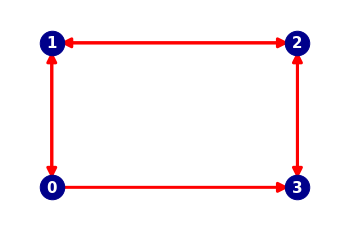

In [9]:
# draw edges, nodes and labels.
nx.draw_networkx_edges(FG,  pos=positions, width=3, edge_color="red", alpha=1, arrowsize=20)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=600)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=15, font_weight='bold', font_color="white")

plt.axis("off")
plt.show()

In [10]:
# To show that moving from Node 4 to Node 1 is not possible
print("From 0 to 3:", nx.shortest_path_length(FG, "0", "3"))
print("From 3 to 0:", nx.shortest_path_length(FG, "3", "0"))

From 0 to 3: 1
From 3 to 0: 3


### 4. Run simulation(s)

In [11]:
def calculate_distance(orig, dest):
    """method to calculate the greater circle distance in meters from WGS84 lon, lat coordinates"""
    
    wgs84 = pyproj.Geod(ellps='WGS84')
    distance = wgs84.inv(orig.x, orig.y, 
                         dest.x, dest.y)[2]
    
    return distance

In [12]:
def calculate_distance_along_path(FG, path):
    """method to calculate the greater circle distance along path in meters from WGS84 lon, lat coordinates"""

    distance_path = 0

    for node in enumerate(path[:-1]):
        orig = nx.get_node_attributes(FG, "geometry")[path[node[0]]]
        dest = nx.get_node_attributes(FG, "geometry")[path[node[0]+1]]
        distance_path += calculate_distance(orig, dest)

        if node[0] + 2 == len(path):
                    break

    return distance_path

In [13]:
def start(env, vessel):
    """method that defines the simulation"""
    while True:
        yield from vessel.move()
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [14]:
# first simulation is from Node 1 to Node 4
path_1 = nx.dijkstra_path(FG, "0", "3")

# second simulation is from Node 4 to Node 1
path_2 = nx.dijkstra_path(FG, "3", "0")

# collect paths in list
paths = [path_1, path_2]

In [15]:
# run a simulation for each path in the list
for path in enumerate(paths):

    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())
    
    # Add graph to environment
    env.FG = FG
    
    # create the transport processing resource
    vessel = Vessel(**data_vessel)
    
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = path[1]
    vessel.geometry = FG.nodes[path[1][0]]['geometry']
    
    # Start the simulation
    env.process(start(env, vessel))
    env.run()
    
    df = pd.DataFrame.from_dict(vessel.log)
    display(df)

    print("Simulation of path {} took {:.1f} seconds".format(path[0] + 1, (env.now - simulation_start.timestamp())))  

    print("Distance of path {} is {:.1f} meters".format(path[0] + 1, calculate_distance_along_path(FG, path[1])))

,Message,Timestamp,Value,Geometry
0,Sailing from node 0 to node 3 start,2022-04-18 22:18:14.000000,0,POINT (0 0)
1,Sailing from node 0 to node 3 stop,2022-04-19 01:23:45.949079,0,POINT (0.1 0)


Simulation of path 1 took 11131.4 seconds
Distance of path 1 is 11131.9 meters


,Message,Timestamp,Value,Geometry
0,Sailing from node 3 to node 2 start,2022-04-18 22:18:14.000000,0,POINT (0.1 0)
1,Sailing from node 3 to node 2 stop,2022-04-19 01:22:31.427695,0,POINT (0.1 0.1)
2,Sailing from node 2 to node 1 start,2022-04-19 01:22:31.427695,0,POINT (0.1 0.1)
3,Sailing from node 2 to node 1 stop,2022-04-19 04:28:03.359933,0,POINT (0 0.1)
4,Sailing from node 1 to node 0 start,2022-04-19 04:28:03.359933,0,POINT (0 0.1)
5,Sailing from node 1 to node 0 stop,2022-04-19 07:32:20.787627,0,POINT (0 0)


Simulation of path 2 took 33246.2 seconds
Distance of path 2 is 33246.8 meters


### 5. Inspect output

In [16]:
df = pd.DataFrame.from_dict(vessel.log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node 3 to node 2 start,2022-04-18 22:18:14.000000,0,POINT (0.1 0)
1,Sailing from node 3 to node 2 stop,2022-04-19 01:22:31.427695,0,POINT (0.1 0.1)
2,Sailing from node 2 to node 1 start,2022-04-19 01:22:31.427695,0,POINT (0.1 0.1)
3,Sailing from node 2 to node 1 stop,2022-04-19 04:28:03.359933,0,POINT (0 0.1)
4,Sailing from node 1 to node 0 start,2022-04-19 04:28:03.359933,0,POINT (0 0.1)
5,Sailing from node 1 to node 0 stop,2022-04-19 07:32:20.787627,0,POINT (0 0)
